In [3]:
%matplotlib inline

## ANOVA

ANOVA, или дисперсионный анализ - методы, которые применяются для установления влияния категориальных переменных (или группировочных признаков) на непрерывную эндогенную переменную.

### One-way ANOVA

Используется в случае, если у нас есть одна зависимая переменная и мы хотим изучить влияние категориальных предикторов (или факторов) на ее величину.

Предположения, лежащие в основе теста:
- Нормальное распределение остатков эндогенной переменной;
- Равенство дисперсий в исследуемых совокупностях;
- Наблюдения на эндогенной переменной в группе - iid.

Нулевая гипотеза:
$$H_0: \mu_1 = \mu_2 = \mu_3. $$


Тест, по сути, сводится к сравнению доли дисперсии, объясненной группировкой, к общей изменчивости признака:
$$ F = \frac{Var_{between}}{Var_{within}}.$$

Традциионная форма представления - таблица ANOVA, из которой понятна суть расчета:

|Источник      |SS                                      |df    |MS                 |F                  |p|
|--------------|----------------------------------------|------|-------------------|-------------------|-|
|Между группами|$\sum_{k}n_k(\bar{X}_k-\bar{X}_{.})^2$  |$k-1$|$\frac{SS_b}{df_b}$|$\frac{MS_b}{MS_w}$|$F_{cr}$|
|Внутри групп  |$\sum_{k}\sum_{i}(x_{ik}-\bar{X}_k)^2$  |$n-k$|$\frac{SS_w}{df_w}$|                   | |
|Общая         |$\sum_{k}\sum_{i}(x_{ik}-\bar{X}_{.})^2$|$n-1$|                   |                   | |

где:
- $k$ - число групп;
- $n$ - объем выборки;
- $\bar{X}_k$ - среднее внутри группы;
- $\bar{X}_.$ - среднее без группировки.

Наблюдаемое значение сравнивается с значениями $F-распределения$ с $df_1$ и $df_2$.

In [6]:
import pandas as pd
from scipy import stats
data = pd.read_csv('PlantGrowth.csv')

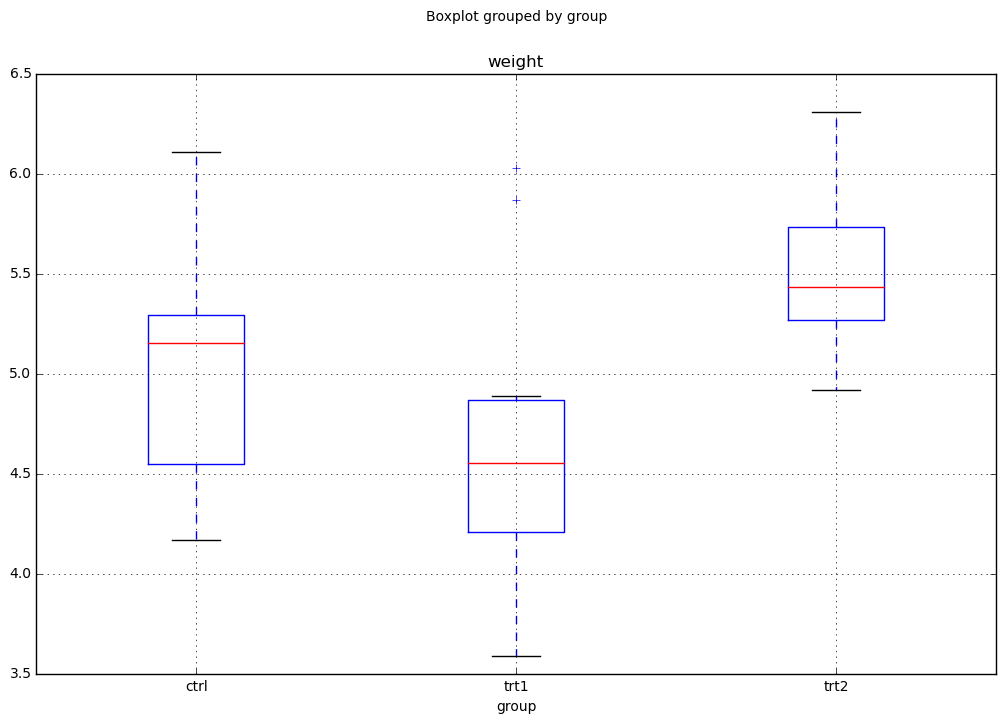

In [7]:
data.boxplot('weight', by='group', figsize=(12, 8))

In [8]:
ctrl = data['weight'][data.group == 'ctrl']
grps = pd.unique(data.group.values)
d_data = {grp:data['weight'][data.group == grp] \
    for grp in pd.unique(data.group.values)}

In [9]:
F, p = stats.f_oneway(d_data['ctrl'], d_data['trt1'], d_data['trt2'])

In [10]:
F

4.846087862380136

In [11]:
p

0.015909958325622899

In [12]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

mod = ols('weight ~ group',
                data=data).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print aov_table

            sum_sq    df         F   PR(>F)
group      3.76634   2.0  4.846088  0.01591
Residual  10.49209  27.0       NaN      NaN


После проведения ANOVA часто используется тест Турки (Turkey's range test).

In [13]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

Тест Турки - один из способов уже знакомой нам множественной проверки гипотез, при которой значимость между каждой парой средних проверяется на значимость:
$$ \mu_i - \mu_j = 0.$$

Говоря неформально, это t-тест для средних, использующий не уровень значимости, а FWER (то есть корректировку на то, что у нас гипотеза не одна, а множество).

http://webspace.ship.edu/pgmarr/Geo441/Readings/Tukey%201949%20-%20Comparing%20Individual%20Means%20in%20the%20Analysis%20of%20Variance.pdf

In [14]:
mc = MultiComparison(data['weight'], data['group'])
result = mc.tukeyhsd()
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     -0.371  -1.0621 0.3201 False 
  0      2     0.494   -0.1971 1.1851 False 
  1      2     0.865    0.1739 1.5561  True 
--------------------------------------------
['ctrl' 'trt1' 'trt2']


### Two-way ANOVA

Иногда нужно проверить влияние не одного эффекта, а сразу нескольких, и оценить их влияние взаимодействий этих эффектов. Для этого применяется two-way ANOVA. Формально, можно увеличивать размерность ANOVA сколько угодно, но тесты более высоких порядков имеют не очень хорошую мощность и интерпретируемость

В случае two-way ANOVA сумма квадратов разбивается следующим образом:

|Источник      |SS                                      |df    |MS                 |F                  |p|
|--------------|----------------------------------------|------|-------------------|-------------------|-|
|Между группами по признаку A|$rb\sum_{a}(\bar{X}_a-\bar{X}_{.})^2$  |$a-1$|$\frac{SS_a}{df_a}$|$\frac{MS_a}{MS_w}$|$F_{cr_a}$|
|Между группами по признаку B|$ra\sum_{b}(\bar{X}_b-\bar{X}_{.})^2$  |$b-1$|$\frac{SS_b}{df_b}$|$\frac{MS_b}{MS_w}$|$F_{cr_b}$|
|Между группами по взаимодействию признаков А и B|$r\sum_{a}\sum_{b}(\bar{X_{ik}}-\bar{X}_b-\bar{X}_a-\bar{X}_{.})^2$  |$(a-1)(b-1)$|$\frac{SS_{ab}}{df_{ab}}$|$\frac{MS_{ab}}{MS_w}$|$F_{cr_b}$|
|Внутри групп  |$\sum_{k}\sum_{i}(X_{ik}-\bar{X}_k)^2$  |$ab(r-1)$|$\frac{SS_w}{df_w}$|                   | |
|Общая         |$\sum_{k}\sum_{i}(X_{ik}-\bar{X}_{.})^2$|$abr-1$|                   |                   | |

где:
- $r$ - объем выборки в каждой ячейке
- $a$ - число категорий признака A
- $b$ - число категорий признака B
- $\bar{X}_i$ - среднее внутри группы a
- $\bar{X}_.$ - среднее без группировки.

Таким образом, two-way Anova - это сразу три теста в одном - на каждый из основных факторов и их взаимодействие. Так как теста 3, то нужно учитывать дополнительную ошибку за счет множественной проверки гипотез:

In [24]:
import numpy as np
p1=[]
p2=[]
p3=[]
times=1000
for j in range(times):
    box = pd.DataFrame()
    box["value"] = np.random.normal(0, 1 , 60)
    box["group1"] = box.index.values % 3
    box["group2"] = box.index.values % 5
    #box.loc[(box['group1'] == 1) & (box['group2'] == 1), "value"] += 0
    #box.loc[(box['group1'] == 1), "value"] += 0
    #box.loc[(box['group1'] == 2) & (box['group2'] == 2), "value"] += 0
    
    box["mean1"] =box["value"].groupby(box["group1"]).transform("mean")
    box["mean2"] =box["value"].groupby(box["group2"]).transform("mean")
    box["mean_cross"] = box["value"].groupby([box.group1, box.group2]).transform("mean")
        
    
    
    ss_within = np.sum(np.square(box["value"] - box["mean_cross"]))
    ss_grp1 = np.sum(np.square(box["mean1"] - box["value"].mean()))
    ss_grp2 = np.sum(np.square(box["mean2"] - box["value"].mean()))
    ss_cross = np.sum(np.square(box["mean_cross"] - box["mean2"] - box["mean1"] +  box["value"].mean()))
    
    
    
    df1 = 2
    df2 = 4
    df_cross = df1*df2
    df_within = 3*5*(4-1)
    
    ms_within = ss_within / df_within
    ms_grp1 = ss_grp1 / df1
    ms_grp2 = ss_grp2 / df2
    ms_cross = ss_cross / df_cross
    
    F_grp1 = ms_grp1 / ms_within
    F_grp2 = ms_grp2 / ms_within
    F_cross = ms_cross / ms_within
    
    p_grp1 = stats.f.cdf(F_grp1, df1, df_within)
    p_grp2 = stats.f.cdf(F_grp2, df2, df_within)
    p_cross = stats.f.cdf(F_cross, df_cross, df_within)
    
    p1.append(p_grp1)
    p2.append(p_grp2)
    p3.append(p_cross)
    
    
np.mean(p1)
np.mean(p2)
np.mean(p3)

p1c=[i>0.95 for i in p1]
p2c=[i>0.95 for i in p2]
p3c=[i>0.95 for i in p3]

p_total=[any(t) for t in zip(p1c, p2c, p3c)]

In [25]:
np.mean(p_total)

0.154